In [14]:
import gym
import os

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
from typing import Dict, Tuple, List
#from pyvirtualdisplay import Display

import highway_env
import gymnasium as gym

from moviepy.editor import concatenate_videoclips, VideoFileClip


  from scipy.ndimage.filters import sobel



In [16]:
pip install highway-env


In [17]:
pip install moviepy

In [4]:
class ReplayBuffer:
    """
    Class representing a simple replay buffer.
    """
    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)

        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)

        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: np.ndarray,
        next_obs: np.ndarray,
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done

        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

In [5]:
class Network(nn.Module):

    def __init__(self, in_dim: int, out_dim: int):
        """
        Instantiates a three-layer feed-forward neural network.
        """
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Performs a forward pass of the neural network.
        """
        return self.layers(x)

In [19]:
class DQNAgent:
    """DQN Agent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including
                           state, action, reward, next_state, done
    """


    def __init__(self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        seed: int,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.8,
      ):
        # Assuming the observation space is 2D
        obs_dim =  np.prod(env.observation_space.shape)
        action_dim = env.action_space.n

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.seed = seed
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()

        # mode: train / test
        self.is_test = False

    def predict(self, state: np.ndarray, determinstic: bool = True) -> np.ndarray:
        """
        Selects an action from the input state using a (potentially) epsilon-greedy policy.
        """
        return self.select_action(state, determinstic)

    def select_action(self, state: np.ndarray, determinstic: bool = True) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        flat_state = state.flatten() if isinstance(state, np.ndarray) else state
        if np.random.random() < self.epsilon:
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:

        """Take an action and return the response of the env."""
        next_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
        next_state = next_state.flatten()

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)

        # Check for additional information if necessary
        # If the environment returns an 'info' dictionary as the fourth value, you can extract it like this:
        # info = step_results[3] if len(step_results) > 3 else {}

        # Flatten next_state if necessary
        #flat_next_state = next_state.flatten() if isinstance(next_state, np.ndarray) else next_state

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        # At the start of the update_model method
        #print("update_model method is called")

        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)


        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Inside the update_model method, after loss.backward() and optimizer.step()
        #print(f"Loss after update {update_cnt}: {loss.item()}")

        return loss.item()

    def train(self, num_frames: int, plotting_interval: int = 200):
        # At the start of the train method
        print("train method is called")
        """Train the agent."""
        self.is_test = False

        state, _ = self.env.reset(seed=self.seed)
        state = state.flatten()

        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state, _ = self.env.reset(seed=self.seed)
                state = state.flatten()

                scores.append(score)
                score = 0

            #print(f"Replay buffer size: {len(self.memory)}")

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1

                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon,
                    self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)

                # Inside the train method, after updating epsilon
                #print(f"Epsilon after frame {frame_idx}: {self.epsilon}")

                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)

        self.env.close()

    def test(self, video_folder: str, num_episodes: int = 1) -> None:
       #Test the agent for a specified number of episodes."""
       self.is_test = True

       for episode in range(num_episodes):
           # for recording a video
        naive_env = self.env
        episode_video_folder = os.path.join(video_folder, f"episode_{episode}")
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=episode_video_folder)

        state, _ = self.env.reset(seed=self.seed)
        state = state.flatten()

        done = False
        score = 0

        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)
            next_state = next_state.flatten()

            state = next_state
            score += reward

        #print(f"Episode {episode} - Score: {score}")
        self.env.close()

        # reset
        self.env = naive_env


    def concatenate_episodes(video_folder, output_file):
        video_clips = []
        for episode_dir in sorted(os.listdir(video_folder)):
            episode_path = os.path.join(video_folder, episode_dir)
            if os.path.isdir(episode_path):
               for file in sorted(os.listdir(episode_path)):
                   if file.endswith('.mp4'):
                      video_clips.append(VideoFileClip(os.path.join(episode_path, file)))

        final_clip = concatenate_videoclips(video_clips)
        final_clip.write_videofile(output_file, codec="libx264")

    video_folder = "/content/videos/dqn" # Your video folder path
    output_file = "/content/videos/dqn/combined_video.mp4" # Output file path
    concatenate_episodes(video_folder, output_file)

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines

        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(
            next_state
        ).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        losses: List[float],
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

Moviepy - Building video /content/videos/dqn/combined_video.mp4.
Moviepy - Writing video /content/videos/dqn/combined_video.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/combined_video.mp4


In [20]:

# ReplayBuffer, Network, and DQNAgent classes as provided

# Initialize the Highway Environment
env = gym.make("highway-fast-v0", render_mode="rgb_array")

env.configure({
    "observation": {
        "type": "Kinematics",


    },
    "action": {
        "type": "DiscreteMetaAction",
    }
    }
)

# Define obs_dim and action_dim based on the environment
#obs_dim = env.observation_space.shape
#action_dim = env.action_space.n  # This is the line you need to add

# Seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# DQN Agent Parameters
num_frames = 10000
memory_size = 1000
batch_size = 32
#gamma = 0.8
target_update = 100
epsilon_decay = 1 / 2000

# Initialize DQN Agent
agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay, seed)




  logger.warn(



cuda


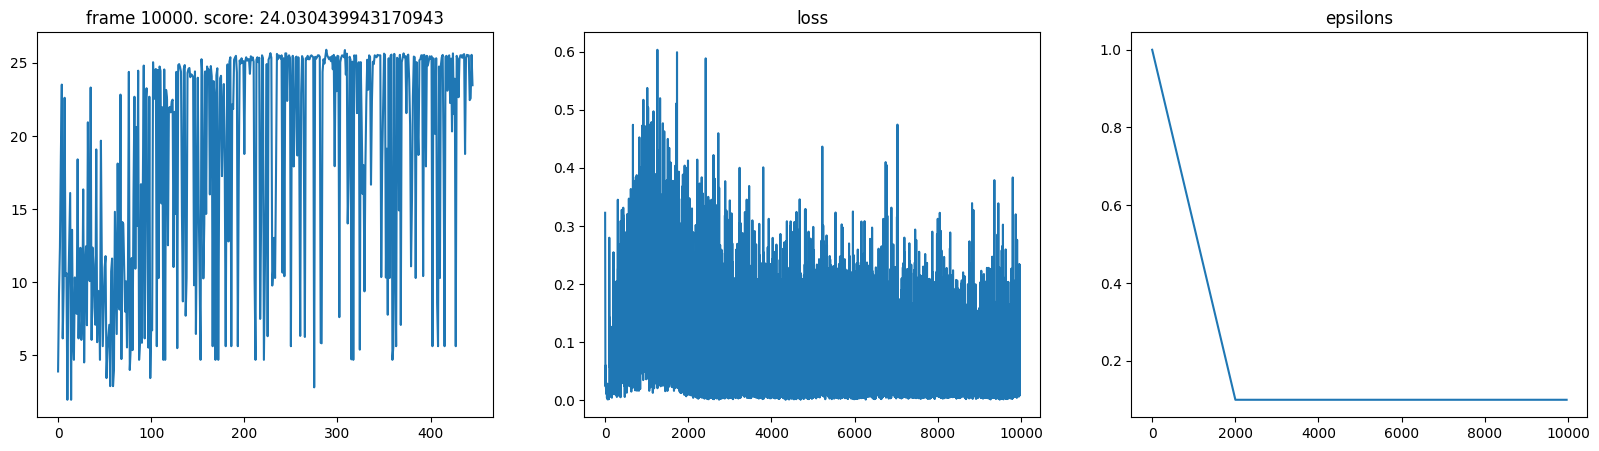

In [ ]:
# Train the Agent
agent.train(num_frames)


In [22]:
video_folder = "videos/dqn"
num_episodes = 10  # Set the number of episodes you want to record
agent.test(video_folder=video_folder, num_episodes=num_episodes)

  logger.warn(



Moviepy - Building video /content/videos/dqn/episode_0/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/dqn/episode_0/rl-video-episode-0.mp4



  logger.warn(



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/episode_0/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/dqn/episode_1/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/dqn/episode_1/rl-video-episode-0.mp4



  logger.warn(



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/episode_1/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/dqn/episode_2/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/dqn/episode_2/rl-video-episode-0.mp4



  logger.warn(



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/episode_2/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/dqn/episode_3/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/dqn/episode_3/rl-video-episode-0.mp4



  logger.warn(



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/episode_3/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/dqn/episode_4/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/dqn/episode_4/rl-video-episode-0.mp4



  logger.warn(



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/episode_4/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/dqn/episode_5/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/dqn/episode_5/rl-video-episode-0.mp4



  logger.warn(



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/episode_5/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/dqn/episode_6/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/dqn/episode_6/rl-video-episode-0.mp4



  logger.warn(



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/episode_6/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/dqn/episode_7/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/dqn/episode_7/rl-video-episode-0.mp4



  logger.warn(



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/episode_7/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/dqn/episode_8/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/dqn/episode_8/rl-video-episode-0.mp4



  logger.warn(



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/episode_8/rl-video-episode-0.mp4
Moviepy - Building video /content/videos/dqn/episode_9/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/dqn/episode_9/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/dqn/episode_9/rl-video-episode-0.mp4


In [23]:
from google.colab import files
files.download("/content/videos/dqn/combined_video.mp4")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>